# 传统图像处理用法

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年4月13日 | Ray | 初次编写文档 | --- |

## 颜色统计模块

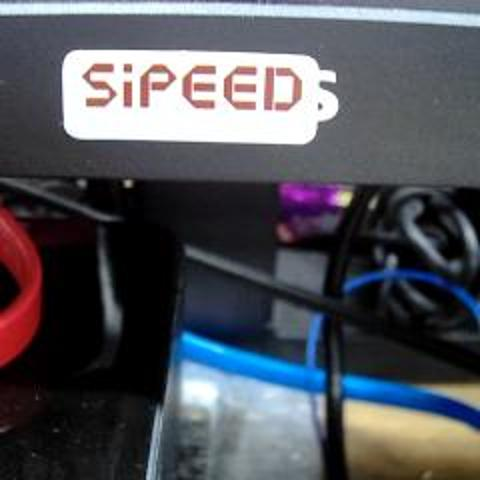

[82, 98, 98, 19, 46, 98, 61, 98, 10, -1, -1, 15, -3, 44, -1, 20, 5, -1, -1, 9, -6, 31, -1, 13]


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
from maix import image,display,camera
ROI=(80,30,15,15)
while True:
    img = camera.capture()
    test = img.get_statistics(roi=ROI)
    display.show(img)
    print(test)